In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score)


from src.config import DADOS_TRATADOS, RANDOM_STATE
from src.helpers import display_metricas

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(palette='bright')

In [2]:
df = pd.read_csv(DADOS_TRATADOS)
df.head(2)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,c,n,k,e,s,s,w,w,o,p,k,s,u,p
1,x,s,y,t,a,c,b,k,e,s,s,w,w,o,p,n,n,g,e


In [3]:
le = LabelEncoder()

X = df.drop(columns=['class'])
y = le.fit_transform(df['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X.columns.to_list()

In [4]:
# Pipeline para tratamento de colunas categóricas
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Transformador de colunas
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols)
])

# Validação cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [5]:
# Criação de Pipelines para avaliação de diferentes modelos
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])

pipe_nb = Pipeline([
    ('prep', preprocessor),
    ('clf', BernoulliNB())
])

pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(random_state=RANDOM_STATE))
])

pipe_knn = Pipeline([
    ('prep', preprocessor),
    ('clf', KNeighborsClassifier())
])

pipes = [pipe_rf, pipe_nb, pipe_lr, pipe_knn]
modelos = ['RandomForest', 'NaiveBayes', 'LogisticRegression', 'KNN']

# Visualização das métricas de desempenho dos modelos
metricas = {
    'Acurácia': 'accuracy',
    'F1-Ponderado': 'f1_weighted',
    'Precisão-Ponderada': 'precision_weighted',
    'Recall-Ponderado': 'recall_weighted',
    'Acurácia-Balanceada': 'balanced_accuracy'
}

df_scores = {}

for nome_metrica, scoring in metricas.items():
    for modelo, pipe in zip(modelos, pipes):
        score = cross_val_score(pipe, X, y, cv=kf, scoring=scoring)
        df_scores.setdefault(nome_metrica, {})[modelo] = format(score.mean(), ".3f")

df_scores = pd.DataFrame(df_scores)
display(df_scores)

,Acurácia,F1-Ponderado,Precisão-Ponderada,Recall-Ponderado,Acurácia-Balanceada
RandomForest,1.000,1.000,1.000,1.000,1.000
NaiveBayes,0.865,0.864,0.870,0.865,0.863
LogisticRegression,0.939,0.939,0.940,0.939,0.939
KNN,0.998,0.998,0.998,0.998,0.998


In [6]:
# Ajuste dos dados ao modelo do Random Forest
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'bruises',
                                                   'odor', 'gill-spacing',
                                                   'gill-size', 'gill-color',
                                                   'stalk-shape',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'ring-number', 'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('clf', RandomForestClassifier(random_state=42))])

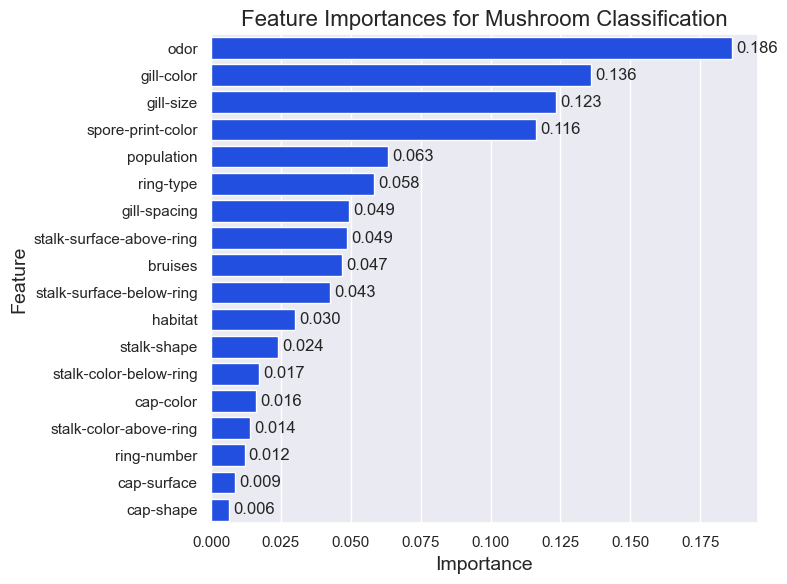

In [7]:
# Visualização da importância das features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pipe_rf['clf'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance)

# Adiciona os rótulos diretamente nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Feature Importances for Mushroom Classification', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

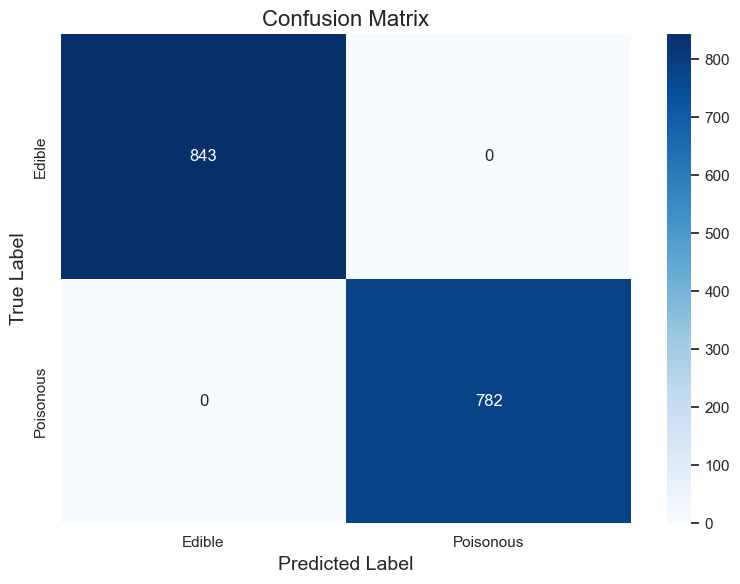

In [8]:
# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, pipe_rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()